In [176]:
%matplotlib inline
import os
import subprocess
import numpy as np
import pandas as pd
from io import StringIO
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML


get_logs_script = "../scripts/get-logs.sh"
servers_path = "../servers.txt"
cred_path = "../aws-brain.pem"

loc = 2
sample_logname = "training-sampler.log"  # "training.log"
scanner_logname = "training-1.log"
performance_logname = "performance-sampler.csv"  # "models/performance.csv"
color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#ff9896',
                  '#9467bd', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2',
                  '#7f7f7f', '#bcbd22', '#17becf']


display(HTML("<style>.container { width:100% !important; }</style>"))


def get_filtered(keywords, filename):
    def contains_any(line):
        for keyword in keywords:
            if keyword in line:
                return True
        return False

    ret = ''
    with open(filename) as f:
        for line in f:
            if contains_any(line):
                ret += line
    return ret


def append_last_ts(df, last_ts):
    last_row = pd.DataFrame(df[-1:].values, columns=df.columns)
    last_row["ts"] = last_ts
    df = df.append(last_row).reset_index(drop=True)
    return df


def get_accept(base_dir):
    c = get_filtered(["new updates"], os.path.join(base_dir, sample_logname))
    df_accepted = pd.read_csv(
        StringIO(c),
        names=["debug", "ts", "_1", "_2", "_3",
               # "tree_size", "update_size",
               "packet_sig", "machine_id", "node_id",
               "node_count", "depth", "gamma", "patch_size", "count_new", "count_updates"])
    df_accepted["accept_root"] = (df_accepted["node_id"] == 0) * 1
    return df_accepted


def get_empty(base_dir):
    c = get_filtered(["empty, reset"], os.path.join(base_dir, sample_logname))
    df_empty = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3", "_4", "_5",
                            "machine_id", "node_id", "node_count", "gamma"])
    return df_empty


def get_reject(base_dir):
    c = get_filtered(["reject for base model mismatch", "reject for sample version mismatch"],
                 os.path.join(base_dir, sample_logname))
    df_reject = pd.read_csv(
        StringIO(c),
        names=["debug", "ts", "_1", "_2", "reason", "scanner", "sampler", "packet"])
    df_reject["model_mismatch"] = (df_reject["reason"] == " reject for base model mismatch") * 1
    df_reject["sample_mismatch"] = (df_reject["reason"] == " reject for sample version mismatch") * 1
    return df_reject


def get_packets(base_dir):
    c = get_filtered(["model_manager, packet,"], os.path.join(base_dir, sample_logname))
    df_packet = pd.read_csv(
        StringIO(c),
        names=["debug", "ts", "_1", "_2", "_3",
               "type", "machine_id", "node_id"])
    types = [" accept nonroot", " accept root", " empty nonroot", " empty root",
             " reject model", " reject sample"]
    for packet_type in types:
        df_packet[packet_type.strip()] = np.cumsum(df_packet["type"] == packet_type)
    return df_packet


def plot_packets(ax1, ax2, df_packets):
    for label in ["accept nonroot", "accept root", "reject model", "reject sample"]:
        df_packets.plot(x="ts", y=label, ax=ax1)
    for label in ["empty nonroot", "empty root"]:
        df_packets.plot(x="ts", y=label, ax=ax2)

    for ax in [ax1, ax2]:
        ax.set_title("Number of Packets Received by the Sampler")
        ax.grid();
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Number of Packets")
        ax.legend(loc=loc);


def plot_packet_node_indices(ax, df_packets):
    if len(ax.shape) == 2:
        flat = []
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                flat.append(ax[i][j])
        ax = flat

    df_packets["node_id"] = df_packets["node_id"].astype(int)
    df_packets["machine_id"] = df_packets["machine_id"].astype(int)
    df_packets[df_packets["type"] == " accept nonroot"].plot.scatter(
        x="ts", y="node_id", ax=ax[0],
    )
    df_packets[df_packets["type"] == " empty nonroot"].plot.scatter(
        x="ts", y="node_id", ax=ax[1],
    )
    df_packets[df_packets["type"] == " accept nonroot"].plot.scatter(
        x="ts", y="machine_id", ax=ax[2],
    )
    df_packets[df_packets["type"] == " empty nonroot"].plot.scatter(
        x="ts", y="machine_id", ax=ax[3],
    )

    for axis, label in zip(ax[:2], ["Accepted", "Empty"]):
        axis.set_title("Node indices of the {} packets".format(label))
        axis.grid();
        axis.set_xlabel("Training Time")
        axis.set_ylabel("Node Index");
    for axis, label in zip(ax[2:], ["Accepted", "Empty"]):
        axis.set_title("Scanner indices of the {} packets".format(label))
        axis.grid();
        axis.set_xlabel("Training Time")
        axis.set_ylabel("Scanner Index");


def plot_strikes(ax, df_packets, df_sample):
    accept_strike, empty_strike = [], []
    curr_strike, last_ts = "", None
    counter = 0
    for ts, pack_type in df_packets[["ts", "type"]].to_numpy().tolist():
        pack_type = pack_type.strip()
        if pack_type not in ["empty nonroot", "accept nonroot"]:
            continue
        if curr_strike != pack_type:
            if curr_strike == "empty nonroot":
                empty_strike.append((last_ts, counter))
            elif curr_strike == "accept nonroot":
                accept_strike.append((last_ts, counter))
            curr_strike = pack_type
            counter = 0
        counter += 1
        last_ts = ts
    if curr_strike == "empty nonroot":
        empty_strike.append((last_ts, counter))
    elif curr_strike == "accept nonroot":
        accept_strike.append((last_ts, counter))

    accept_strike = np.array(accept_strike)
    empty_strike = np.array(empty_strike)
    ax.scatter(accept_strike[:, 0], accept_strike[:, 1], label="Accept strike")
    ax.scatter(empty_strike[:, 0], empty_strike[:, 1], label="Empty strike")

    label = "New sample"
    for ts in df_sample["ts"]:
        ax.axvline(x=ts, ls='--', alpha=0.5, color="gray", label=label);
        label = None

    ax.grid()
    ax.legend(loc=loc);
    ax.set_xlabel("Timestamp");
    ax.set_ylabel("Length of the strikes")
    ax.set_title("Accept/Reject Strikes");


def get_assignment(base_dir):
    c = get_filtered(["assign,"], os.path.join(base_dir, sample_logname))
    df_assign = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3",
                            "machine_id", "node_id", "last_gamma", "curr_gamma"])
    return df_assign


def plot_assignment(ax, df_assign):
    ax.plot(df_assign.ts, np.arange(0, df_assign.shape[0]))
    ax.grid()
    ax.set_title("Total number of assignments")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Number of assignments");


def get_gamma(base_dir):
    c = get_filtered(["gamma update,"], os.path.join(base_dir, sample_logname))
    df_bcast_gamma = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3", "gamma_type",
                            "gamma_version", "gamma", "root_gamma", "shrink_factor"])
    return df_bcast_gamma


def plot_gamma(ax, df_bcast_gamma):
    df_bcast_gamma["gamma"] = df_bcast_gamma["gamma"].astype(float)
    df_bcast_gamma["root_gamma"] = df_bcast_gamma["root_gamma"].astype(float)
    df_bcast_gamma.plot(
        x="ts", y="gamma", ax=ax, label="gamma",
    )
    df_bcast_gamma.plot.scatter(
        x="ts", y="gamma", ax=ax, label="gamma",
    )
    df_bcast_gamma.plot(
        x="ts", y="root_gamma", ax=ax, label="root_gamma", color="orange"
    )
    df_bcast_gamma.plot.scatter(
        x="ts", y="root_gamma", ax=ax, label="root_gamma", color="orange"
    )

    ax.set_title("Values of Gamma over Training Time")
    ax.grid();
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Gamma")
    ax.legend(loc=loc);


def get_sample(base_dir):
    c = get_filtered(["finished, generate sample"], os.path.join(base_dir, sample_logname))
    df_sample = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2", "_3", "_4",
                            "num_scanned", "total_sample", "total_pos", "total_unique", "pos_unique",
                            "model_size"])
    df_sample["total_neg"] = df_sample["total_sample"] - df_sample["total_pos"]
    df_sample["neg_unique"] = df_sample["total_unique"] - df_sample["pos_unique"]
    return df_sample


def plot_sample(ax, df_sample):
    df_sample["total_pos"] = df_sample["total_pos"].astype(float)
    df_sample["total_neg"] = df_sample["total_neg"].astype(float)
    df_sample["neg_unique"] = df_sample["neg_unique"].astype(float)
    df_sample["pos_unique"] = df_sample["pos_unique"].astype(float)
    df_sample.plot.scatter(
        x="ts", y="total_pos", ax=ax, label="Positive", color="orange",
    )
    df_sample.plot.scatter(
        x="ts", y="total_neg", ax=ax, label="Negative",
    )
    df_sample.plot(
        x="ts", y="neg_unique", ax=ax, label="Unique negative",
    )
    df_sample.plot(
        x="ts", y="pos_unique", ax=ax, label="Unique positive",
    )
    ax.grid();
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Number of examples");
    ax.set_title("Number of the positives and the negatives in the sample");


def get_packet_status(base_dir):
    c = get_filtered(["packet stats, status,"], os.path.join(base_dir, sample_logname))
    c = '\n'.join([', '.join(line.split(', ', 19)[:19]) for line in c.split('\n')])
    df_packet = pd.read_csv(
        StringIO(c),
        names=["debug", "ts", "_1", "_2", "_3", "_4",
               "total_packets", "empty_packets", "accept_packets", "rejected_packets",
               "accept_root_packets", "accept_nonroot_packets", "empty_root_packets", "empty_nonroot_packets",
               "rejected_packets_model", "rejected_packets_sample",
               "avg_accept_nonroot_rate", "last_accept_nonroot_rate", "condition",])
    df_packet["avg_accept_nonroot_rate"] = df_packet["avg_accept_nonroot_rate"].astype(float)
    df_packet["last_accept_nonroot_rate"] = df_packet["last_accept_nonroot_rate"].astype(float)
    return df_packet


def plot_packet_status(ax, df_pack_status):
    df_pack_status.plot(
        x="ts", y="avg_accept_nonroot_rate", ax=ax, label="avg accept rate",
    )
    df_pack_status["last_accept_nonroot_rate"] = df_pack_status["last_accept_nonroot_rate"].astype(float)
    df_pack_status.plot.scatter(
        x="ts", y="last_accept_nonroot_rate", ax=ax, label="accept rate", color="orange",
    )
    ax.set_title("Accept rate over training time")
    ax.grid();
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Accept rate")
    ax.legend(loc=loc);


def get_model_stats(base_dir):
    c = get_filtered(["model stats, status,"], os.path.join(base_dir, sample_logname))
    # TODO
    c = c.replace(". ", ", ")
    df_model = pd.read_csv(
        StringIO(c),
        names=["debug", "ts", "_1", "_2", "_3",
               "tree_size", "update_size", "num_roots",
               "prefix", "gamma_version", "sig", "avail_nodes", "avail_root", "max_num_trees", "max_depth"])
    return df_model


def plot_model_stats(ax, df_model, df_accept):
    '''
    df_accept["total_patch_size"] = np.cumsum(df_accept["patch_size"])
    df_accept.plot(
        x="ts", y="total_patch_size", ax=ax[0],
    )
    '''
    df_model.plot(
        x="ts", y="tree_size", ax=ax[0],
    )
    df_model.plot(
        x="ts", y="num_roots", ax=ax[0],
    )
    df_model.plot(
        x="ts", y="update_size", ax=ax[0],
    )
    # 
    df_model.plot(
        x="ts", y="avail_nodes", ax=ax[1],
    )
    df_model.plot(
        x="ts", y="avail_root", ax=ax[1],
    )

    for it in ax:
        it.set_title("Model size over training time")
        it.grid();
        it.set_xlabel("Timestamp")
        it.set_ylabel("Model size")
        it.legend(loc=loc);


def get_performance(base_dir):
    c = get_filtered([""], os.path.join(base_dir, performance_logname))
    df_perf = pd.read_csv(
        StringIO(c), names=["filename", "ts", "tree_size", "node_count", "loss", "AUPRC", "AUROC", "error_rate"],
    )
    return df_perf


def plot_perf(ax, df_perf):
    if len(ax.shape) == 2:
        flat = []
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                flat.append(ax[i][j])
        ax = flat
    df_perf.plot(
        x="ts", y="loss", ax=ax[0],
    )
    df_perf.plot(
        x="ts", y="AUROC", ax=ax[1],
    )
    df_perf.plot(
        x="ts", y="AUPRC", ax=ax[2],
    )
    df_perf.plot(
        x="ts", y="node_count", ax=ax[3],
    )

    for axis, label in zip(ax, ["loss", "AUROC", "AUPRC", "Number of nodes"]):
        axis.set_title("{} on the Testing Dataset".format(label))
        axis.grid();
        axis.set_xlabel("Training Time")
        axis.set_ylabel(label)
        axis.legend(loc=loc);
    ax[3].set_title("Number of nodes over training time")


def get_ess(base_dir):
    c = get_filtered(["loader-reset"], os.path.join(base_dir, scanner_logname))
    df_ess = pd.read_csv(
        StringIO(c), names=["debug", "ts", "_1", "_2",
                            "ess"],
    )
    return df_ess


def plot_ess(ax, df_ess):
    df_ess = get_ess(base_dir)
    df_ess.plot(
        x="ts", y="ess", ax=ax,
    )

    ax.set_title("Effective Sample Size over Training Time")
    ax.grid();
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Effective Sample Size")
    ax.legend(loc=loc);


def get_data(with_model):
    print("Script: {}\nServers: {}\nCredential: {}".format(
        os.path.exists(get_logs_script), os.path.exists(servers_path), os.path.exists(cred_path)))
    c = 'n'
    if with_model:
        c = 'y'
    result = subprocess.check_output(
        "{0:} {1:} {2:} {3:} {4:}".format(get_logs_script, os.path.abspath(cred_path), servers_path, base_dir, c),
        stderr=subprocess.STDOUT,
        shell=True)
    print(result.decode("utf-8"))


def get_ax(row, col):
    return plt.subplots(row, col, figsize=(10 * col, int(row * 6 * 1.25)))

In [179]:
def show_plots(base_dir, comp_ax=None):
    if False:
        get_data(True)

    with open(os.path.join(base_dir, sample_logname)) as f:
        all_lines = f.readlines()
        while not all_lines[-1].startswith("DEBUG"):
            del all_lines[-1]
        last_ts = float(all_lines[-1].split(", ", 2)[1])
    ret_ax = []
    ax_idx = 0

    try:
        df_perf = get_performance(base_dir)
        df_perf = append_last_ts(df_perf, last_ts)
        if comp_ax is None:
            fig, ax = get_ax(1, 4)
            ret_ax.append((fig, ax))
        else:
            (fig, ax) = comp_ax[ax_idx]
            ax_idx += 1
        plot_perf(ax, df_perf)
        ax[0].set_ylim(0.05, 0.15)
    except:
        pass

    df_packet_status = get_packet_status(base_dir)
    df_packet_status = append_last_ts(df_packet_status, last_ts)

    df_packet = get_packets(base_dir)
    df_packet = append_last_ts(df_packet, last_ts)

    df_gamma = get_gamma(base_dir)
    df_gamma = append_last_ts(df_gamma, last_ts)

    if comp_ax is None:
        fig, ax = get_ax(1, 4)
        ret_ax.append((fig, ax))
    else:
        (fig, ax) = comp_ax[ax_idx]
        ax_idx += 1
    plot_gamma(ax[0], df_gamma)
    plot_packet_status(ax[1], df_packet_status)
    plot_packets(ax[2], ax[3], df_packet)

    if comp_ax is None:
        fig, ax = get_ax(1, 4)
        ret_ax.append((fig, ax))
    else:
        (fig, ax) = comp_ax[ax_idx]
        ax_idx += 1

    df_model_stats = get_model_stats(base_dir)
    df_accept = get_accept(base_dir)
    df_model_stats = append_last_ts(df_model_stats, last_ts)
    df_accept = append_last_ts(df_accept, last_ts)
    plot_model_stats([ax[0], ax[1]], df_model_stats, df_accept)

    df_assign = get_assignment(base_dir)
    df_assign = append_last_ts(df_assign, last_ts)
    plot_assignment(ax[2], df_assign)

    df_sample = get_sample(base_dir)
    df_sample = append_last_ts(df_sample, last_ts)
    plot_sample(ax[3], df_sample)

    if comp_ax is None:
        fig, ax = get_ax(1, 4)
        ret_ax.append((fig, ax))
    else:
        (fig, ax) = comp_ax[ax_idx]
        ax_idx += 1
    plot_packet_node_indices(ax, df_packet)

    if comp_ax is None:
        fig, ax = get_ax(1, 2)
        ret_ax.append((fig, ax))
    else:
        (fig, ax) = comp_ax[ax_idx]
        ax_idx += 1

    plot_strikes(ax[0], df_packet, df_sample)
    plot_ess(ax[1], get_ess(base_dir))

    if comp_ax is not None:
        return comp_ax
    return ret_ax


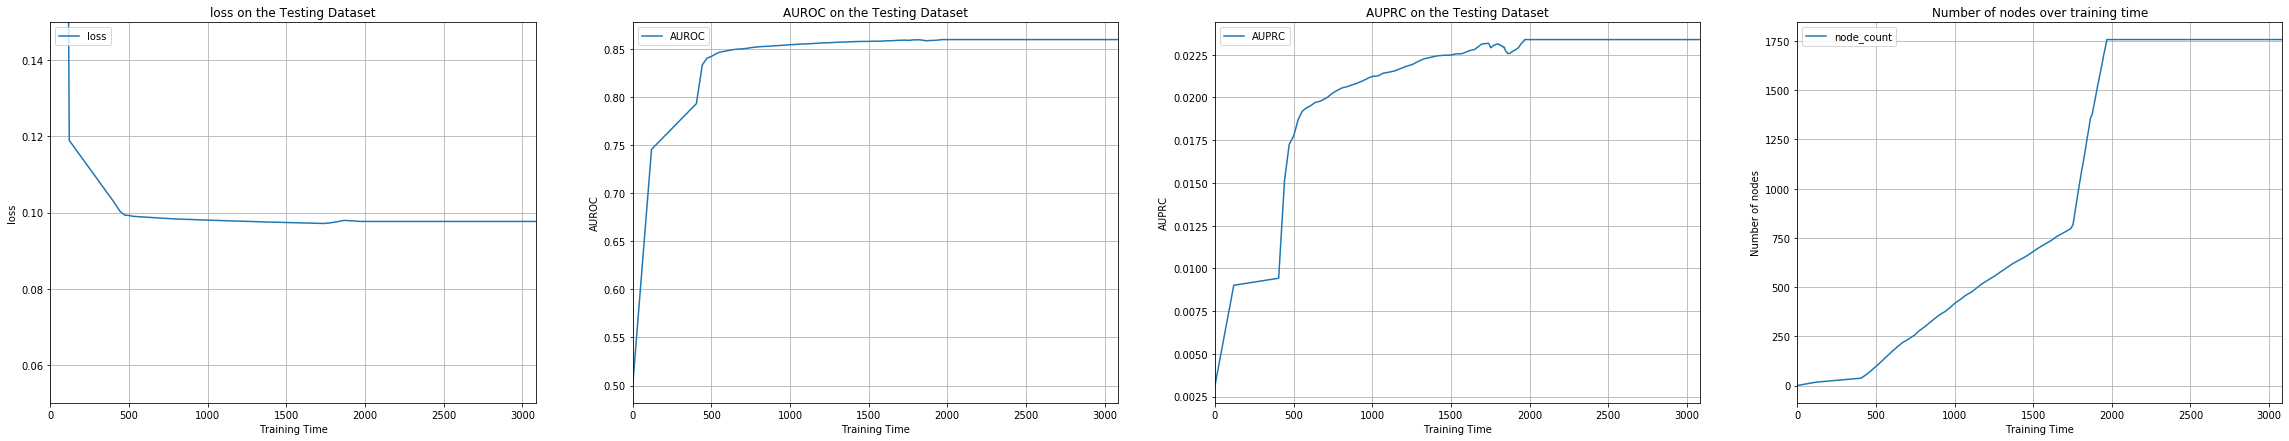

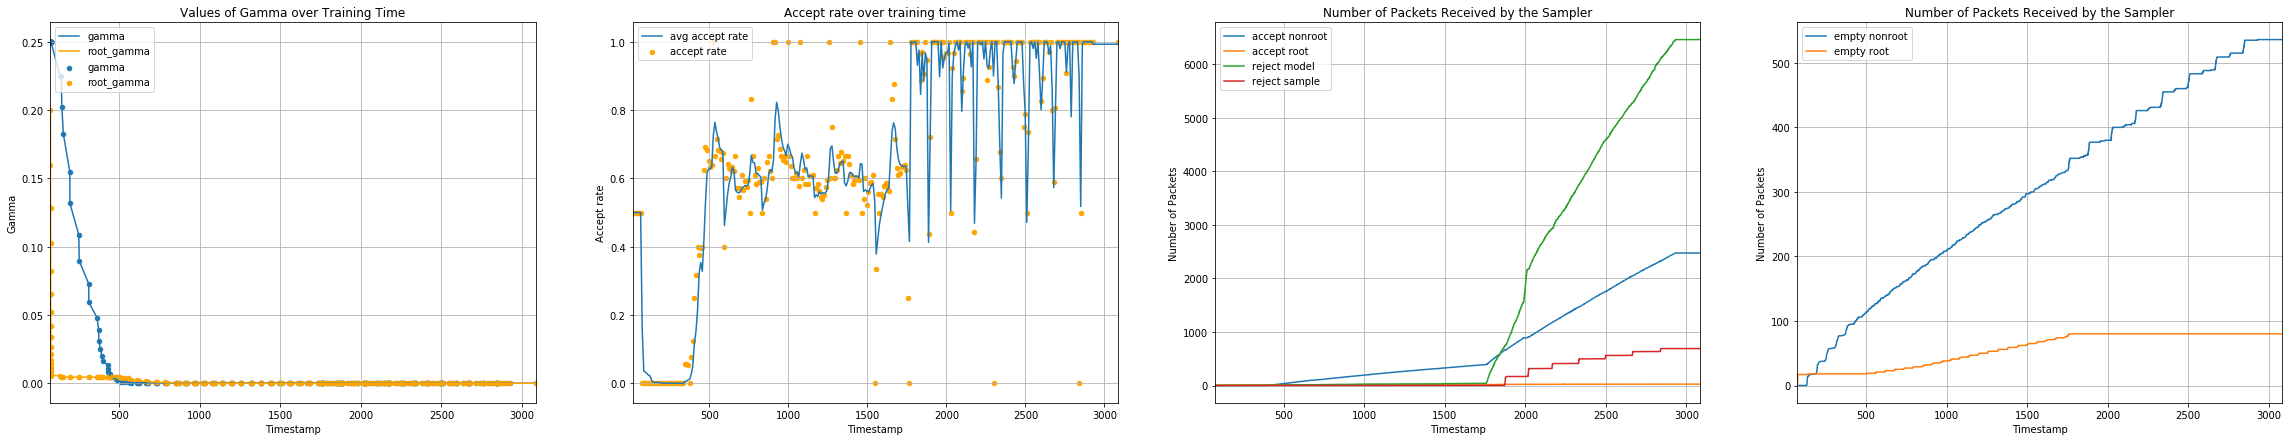

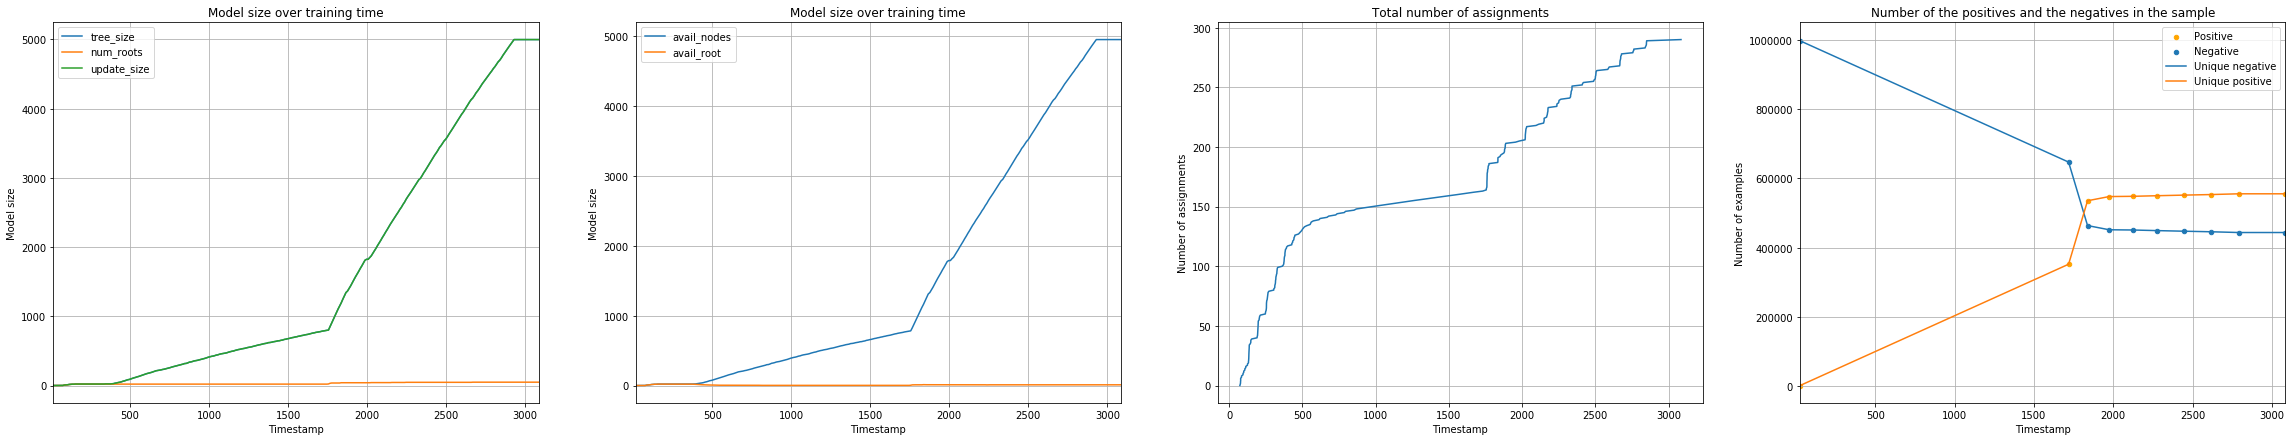

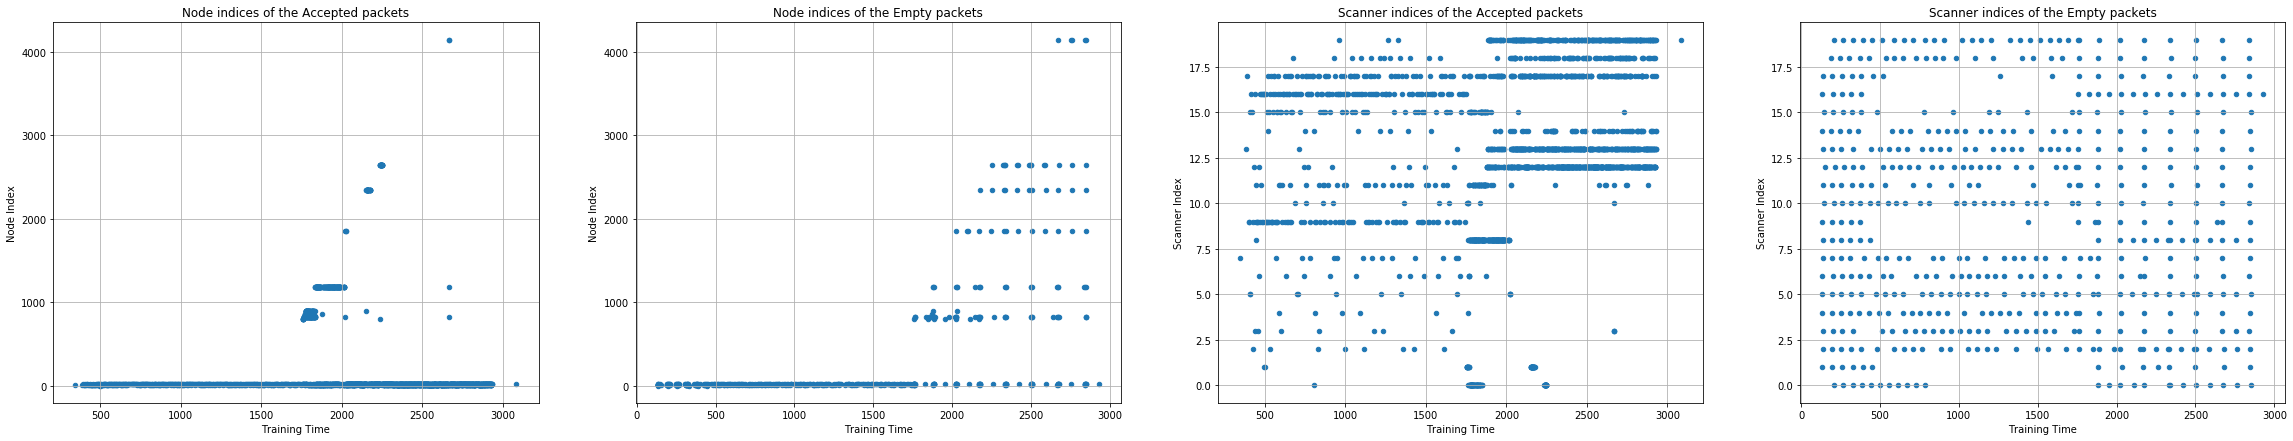

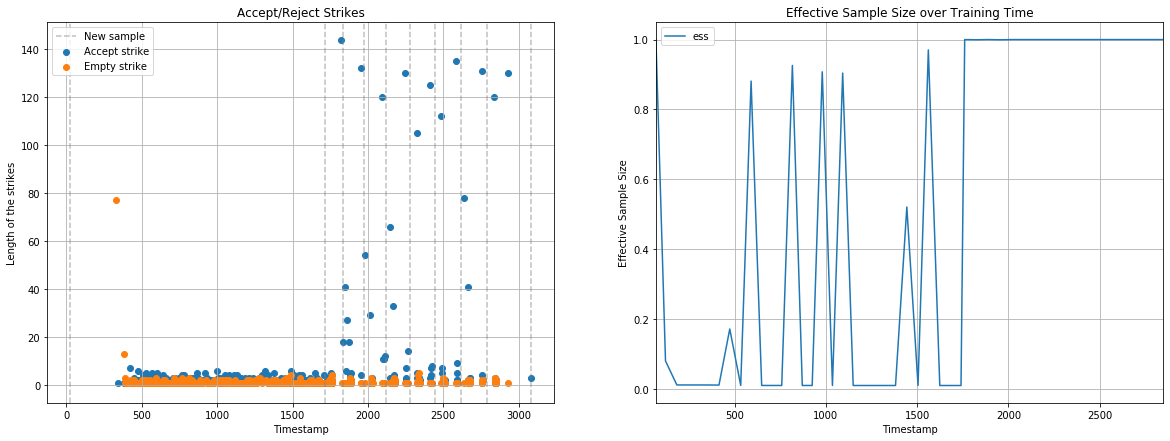

In [180]:
base_dir = "./dl-logs/new-five-init-20-early-term2"  # 20 machines, gamma decreases too fast
ret_ax20 = show_plots(base_dir)

# base_dir = "./dl-logs/new-five-init-5-suc2"  # 5 machines, it works
# ret_ax5 = show_plots(base_dir)

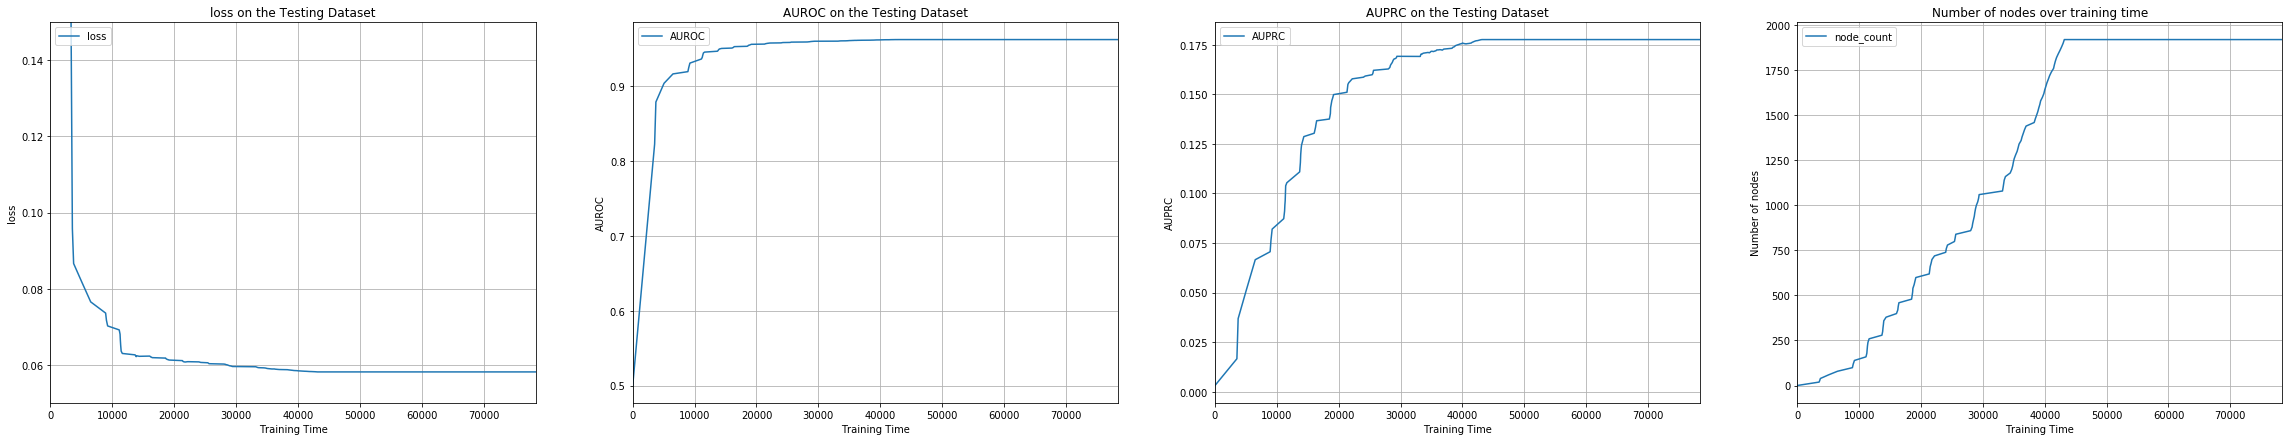

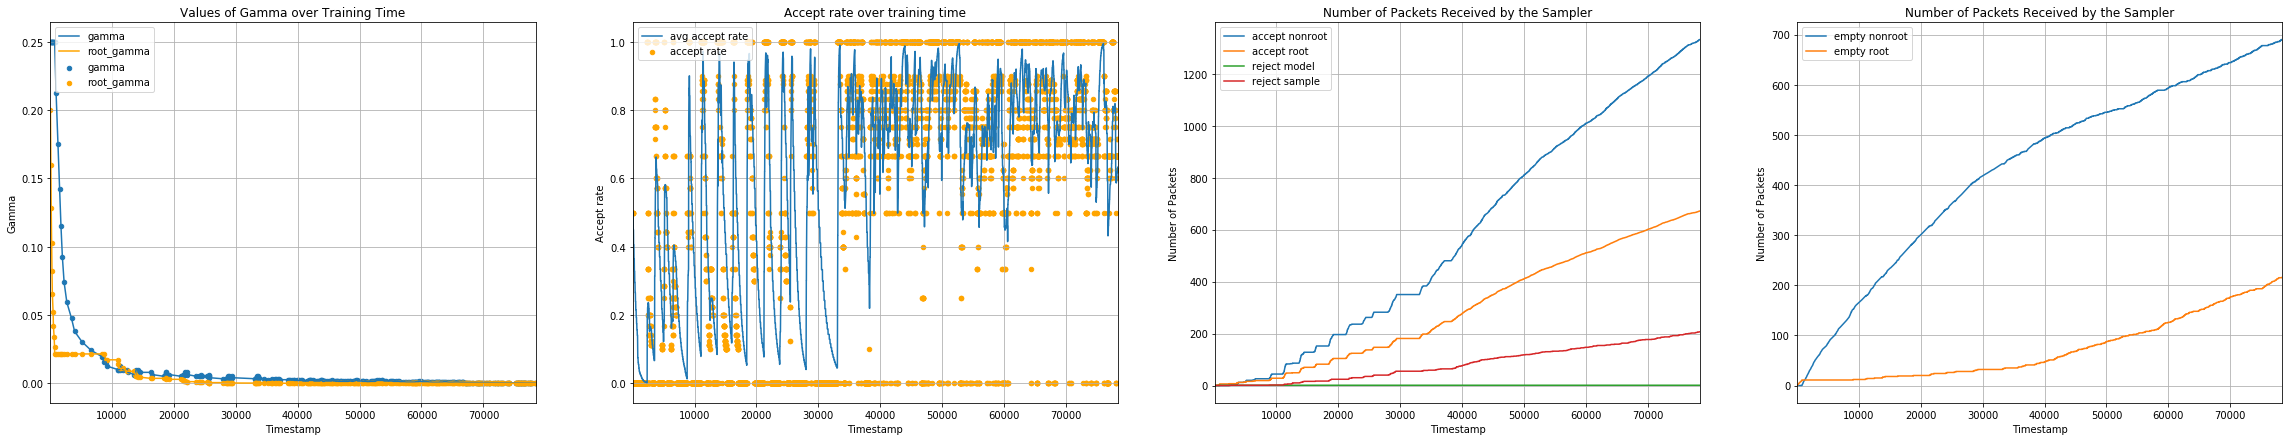

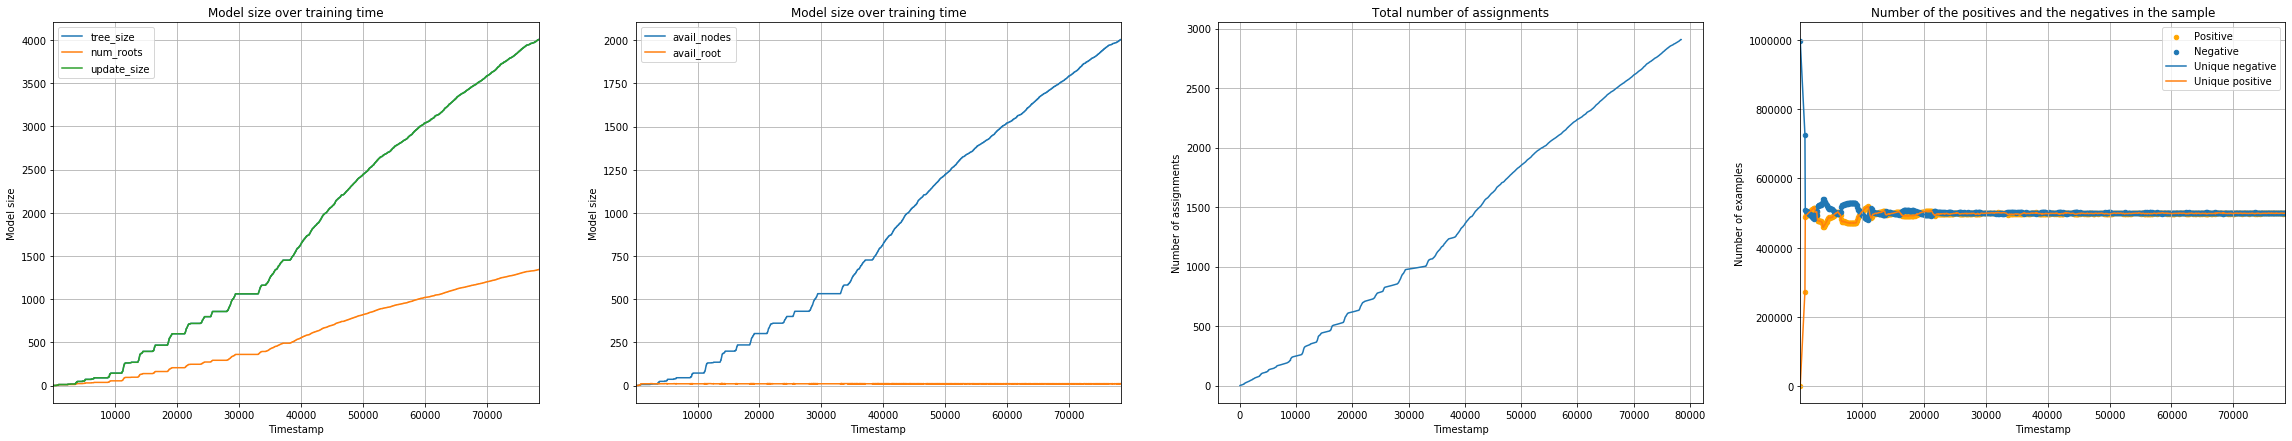

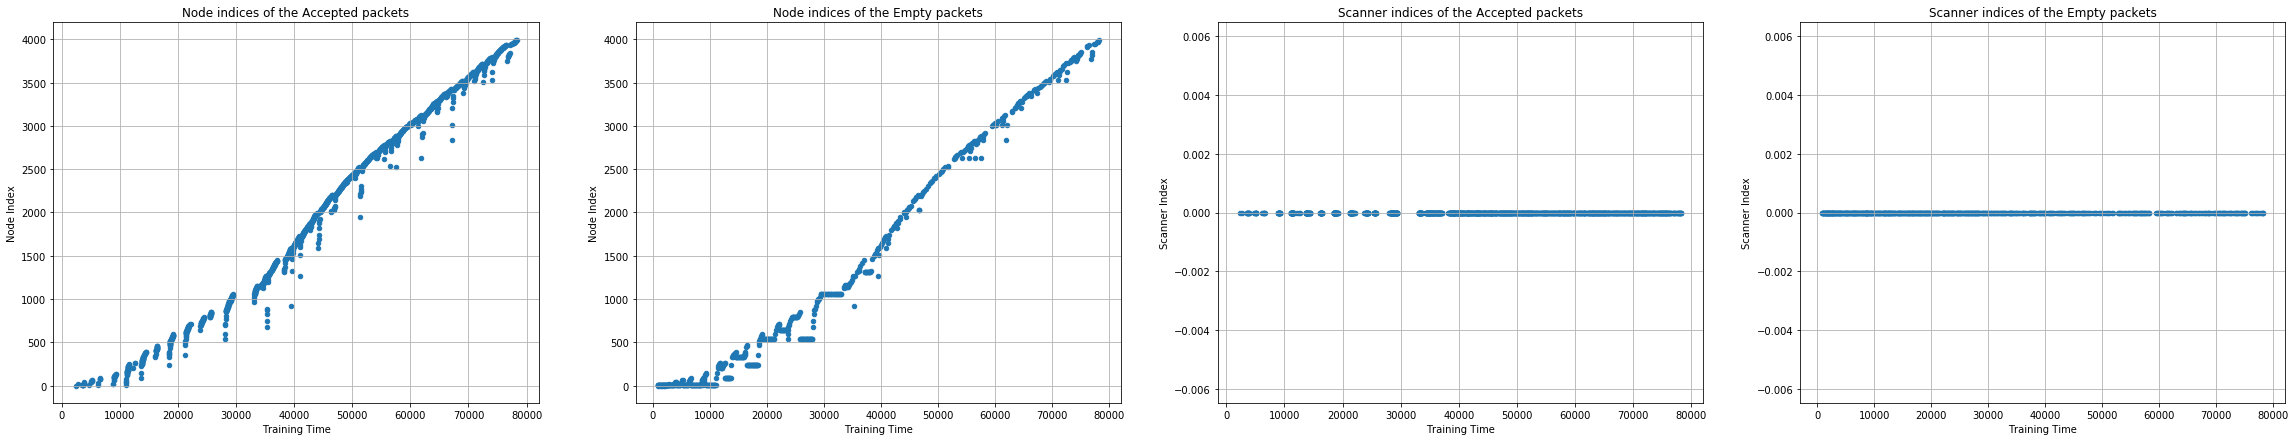

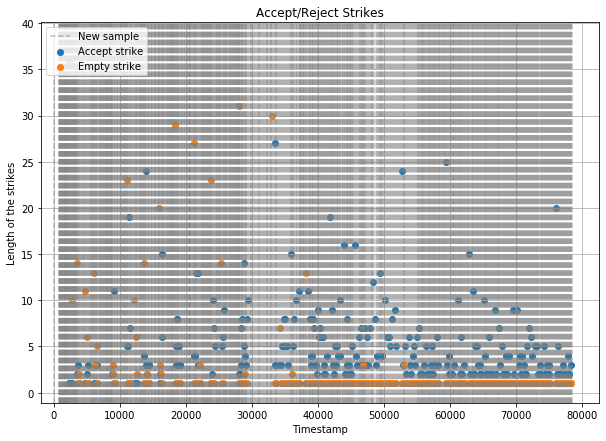

In [140]:
base_dir = "./dl-logs/new-five-init-1"
ret_ax1 = show_plots(base_dir, None)
# ret_ax[0][0]

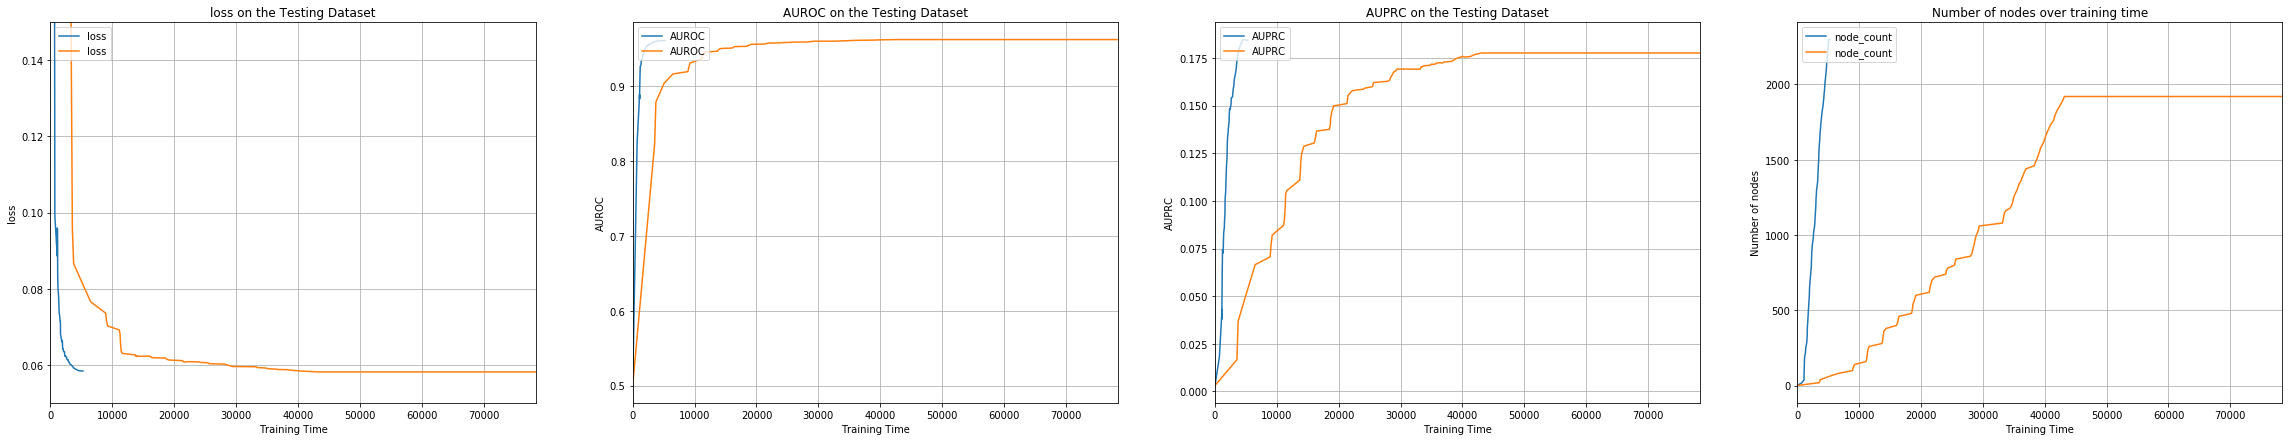

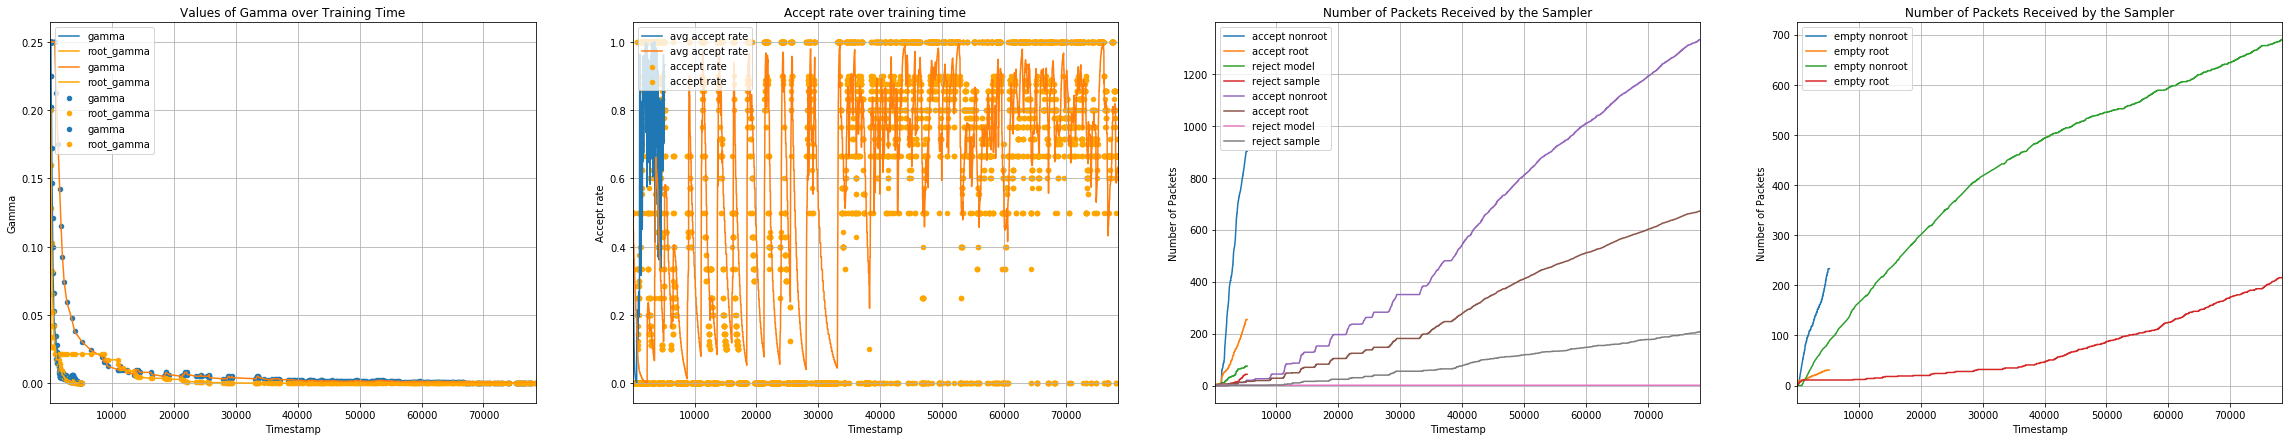

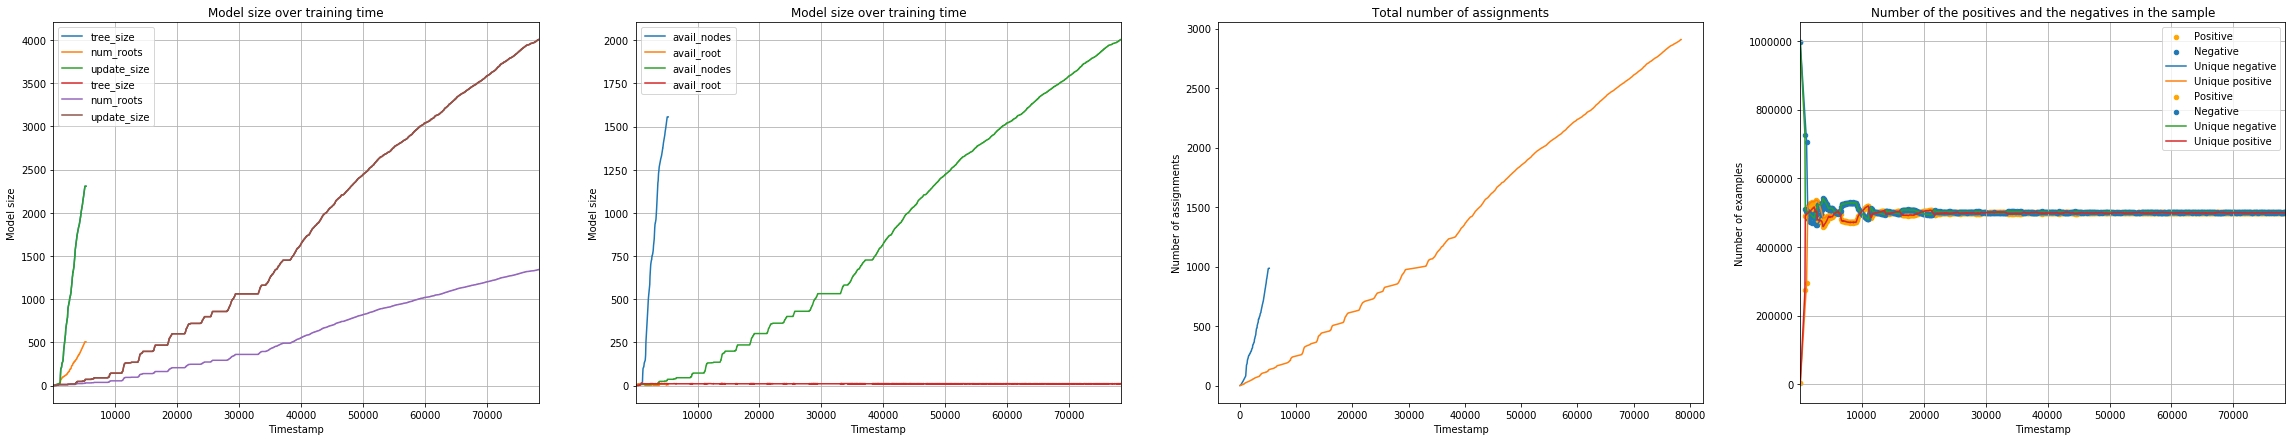

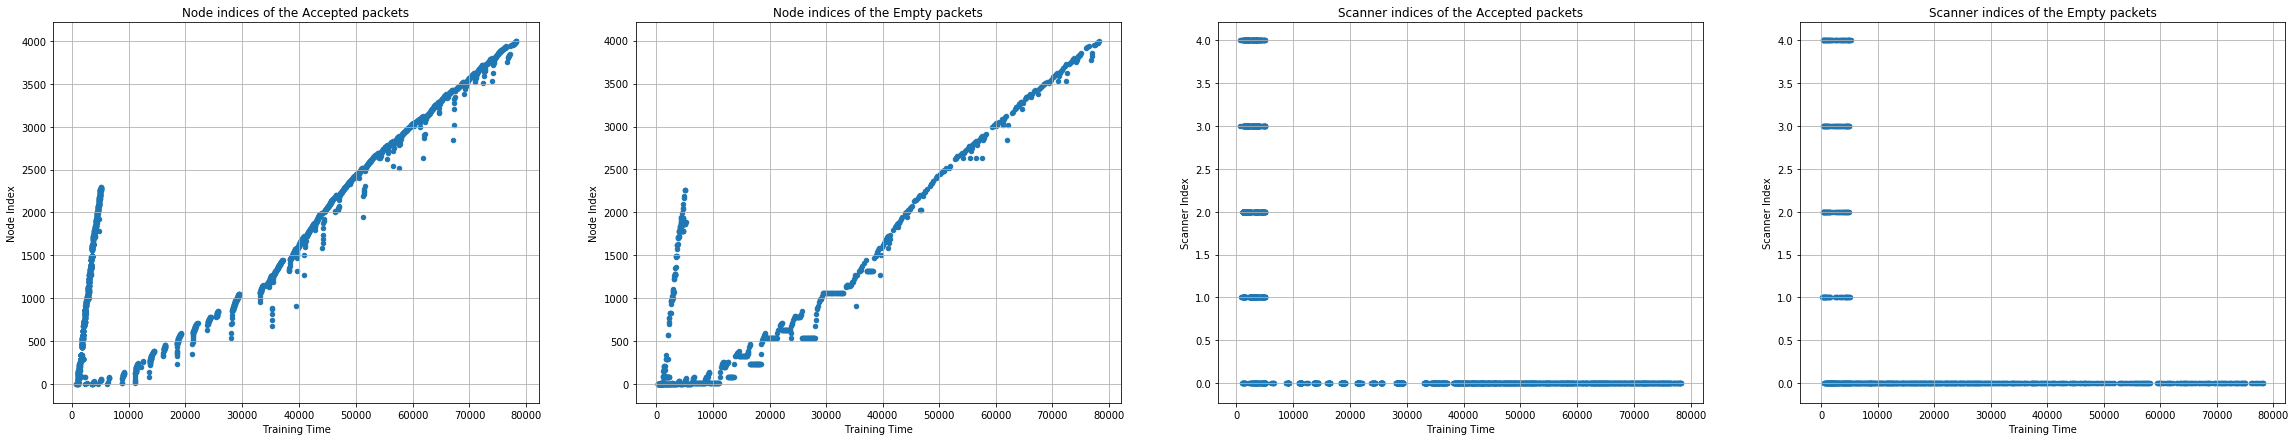

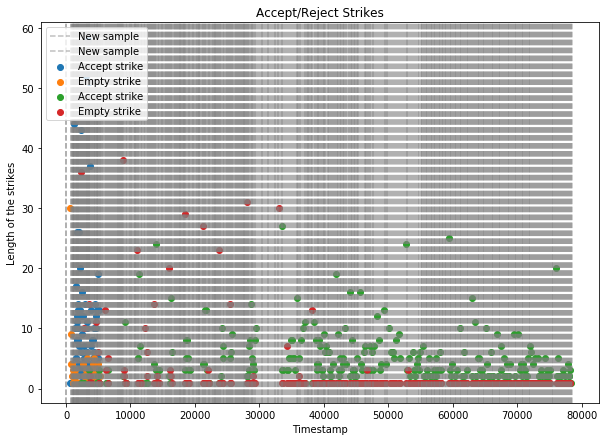

In [150]:
base_dir = "./dl-logs/new-five-init-5-suc2"  # 5 machines, it works
ret_ax5 = show_plots(base_dir)

base_dir = "./dl-logs/new-five-init-1"
ret_ax1 = show_plots(base_dir, ret_ax5)
# ret_ax[0][0]

# Issues

1. Node counts cannot be real-time, because the extend nodes are generated after the sample is generated, which is when the node counts are updated.

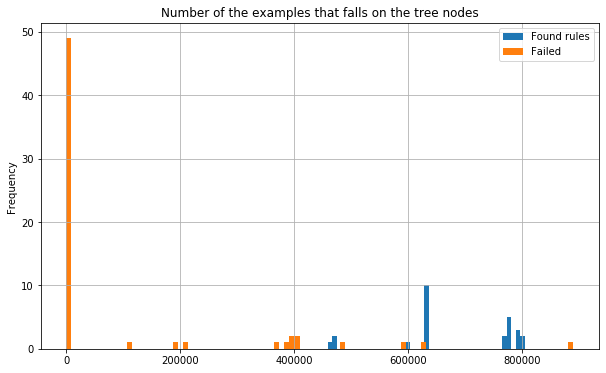

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

df_accepted = get_accept(base_dir)
node_counts = df_accepted["node_count"]
node_counts.plot.hist(bins=100, ax=ax, label="Found rules")

df_empty = get_empty(base_dir)
node_counts = df_empty["node_count"]
node_counts.plot.hist(bins=100, ax=ax, label="Failed")

ax.set_title("Number of the examples that falls on the tree nodes");
ax.legend();
ax.grid();